In [65]:
# import required libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import urllib
import time
print("Required libraries loaded successfully")

Required libraries loaded successfully


In [66]:
def literary_rate_data(url):
    """Returns the literacy rate cleaned up dataframe"""
    #url = "https://www.census2011.co.in/literacy.php"
    header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) \
        Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
    }

    r = requests.get(url, headers=header)

    dfs = pd.read_html(r.text)
    # print(f'Total tables: {len(dfs)}')
    df = dfs[0]

    # print(df.columns)
    df.drop(columns=["#"], inplace=True)
    #print(df.head())
    #return  df.sort_values(["Male"], ascending=[False], inplace=True)
    return (df.sort_values(["Male"], ascending=[False]))
    #df.head(5)

In [67]:
def urban_rural_pop_data(url):
    """Returns the rural urbal population dataframe in % percent statewise"""
    delay = 5
    max_retries = 3
    for _ in range(max_retries):
        try:
            df = pd.read_excel(url
                #r"https://censusindia.gov.in/nada/index.php/catalog/42555/download/46181/2011-IndiaState-0000.xlsx"
                #url
            )
            
            break                # do not loop after a successfull download...
        except urllib.error.URLError:
            time.sleep(delay)
            delay *= 2
    else:                # signal an abort if download was not possible
        print(f"Failed for {url} after {max_retries} attempt")
        # or if you want to abort the script
        # raise Exception(f"Failed for {url} after {max_retries} attempt")
    """df = pd.read_excel(url
        #r"https://censusindia.gov.in/nada/index.php/catalog/42555/download/46181/2011-IndiaState-0000.xlsx"
        #url
    )"""
    pd.options.display.float_format = "{:.2f}".format  # To remove scientifc numbers
    #df.head()
    df_new = duckdb.query(
        f""" 
    SELECT NAME  
    ,round(cast(URBAN_POP*100 as float)/TOTAL_POP, 2) as "Urban Population" 
    ,round(cast(RURAL_POP*100 as float)/TOTAL_POP, 2) as "Rural Population" 
    FROM 
    (
        SELECT NAME, SUM(TOTAL_POP) TOTAL_POP, SUM(RURAL_POP) RURAL_POP, SUM(URBAN_POP) URBAN_POP  
        FROM 
        (
            select Name, Tot_P as Total_pop, Null as Rural_pop, null as Urban_pop from df where TRU = 'Total' 
            UNION
            select Name, Null as Total_pop, Tot_P as Rural_pop, null as Urban_pop from df where TRU = 'Rural'
            UNION
            select Name, Null as Total_pop, Null as Rural_pop, Tot_P as Urban_pop from df where TRU = 'Urban'
        ) A GROUP BY NAME
    ) B
    """
    ).to_df()
    return df_new

In [68]:
# Reference: https://colab.research.google.com/drive/1lKuaZUp8LggiDFbct0-DcUDMMYdvO4Tp?usp=sharing#scrollTo=sBkAKOCTYOek


def color_title(
    labels, colors, textprops={"size": "large"}, ax=None, y=1.013, precision=10**-2
):

    "Creates a centered title with multiple colors. Don't change axes limits afterwards."

    if ax == None:
        ax = plt.gca()

    plt.gcf().canvas.draw()
    transform = ax.transAxes  # use axes coords

    # initial params
    xT = 0  # where the text ends in x-axis coords
    shift = 0  # where the text starts

    # for text objects
    text = dict()

    while (np.abs(shift - (1 - xT)) > precision) and (shift <= xT):
        x_pos = shift

        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass

            text[label] = ax.text(
                x_pos, y, label, transform=transform, ha="left", color=col, **textprops
            )

            x_pos = text[label].get_window_extent().transformed(transform.inverted()).x1

        xT = x_pos  # where all text ends

        shift += precision / 2  # increase for next iteration

        if x_pos > 1:  # guardrail
            break


In [69]:
def create_dumbell(df, xaxis1, yaxis1, xaxis2, yaxis2,filename="dumbell_plot"):
    """ creating the dumbell plot using matplotlib based on dataframe passed as input

    Args:
        df (dataframe): input df to be used as source data
        xaxis1 (series): 
        yaxis1 (series): 
        xaxis2 (series): 
        yaxis2 (series): 
    """
    # Create playground
    fig, ax = plt.subplots(figsize=(10, 8))

    # Visuals
    df.plot.scatter(x=xaxis1, y=yaxis1, ax=ax, color="#1E1E1E", s=60)
    df.plot.scatter(x=xaxis2, y=yaxis2, ax=ax, c="#FC7D0B", s=60)
    ax.hlines(
        y=range(0, len(df.index)),
        xmin=df[xaxis2],
        xmax=df[xaxis1],
        linewidth=5,
        color="#BDBDBD",
        zorder=0,
    )

    # Background and remove noise
    ax.set_facecolor("#F5F5F5")
    ax.spines[["bottom", "top", "left", "right"]].set_visible(False)
    ax.tick_params(axis="both", length=0)
    ax.set(ylabel=None)
    ax.set(xlabel=None)

    # Title color
    label_list = ["Population divide ", xaxis2, " and ", xaxis1, " Statewise"]
    colors = ["#969FA7", "#FC7D0B", "#969FA7", "#1E1E1E", "#969FA7"]
    color_title(label_list, colors)

    #plt.text(0, -4, "Source: Census India 2011", c="#969FA7")
    # plt.show()
    filename
    xplot = 40 if "literacy" in filename.lower() else 0
    plt.text(xplot, -4, "Source: Census India 2011", c="#969FA7")

    plt.savefig(
        #"RuralUrbanPopulationStatewise.png",
        filename,
        dpi=300,
        facecolor="#F5F5F5",
        bbox_inches="tight",
    )


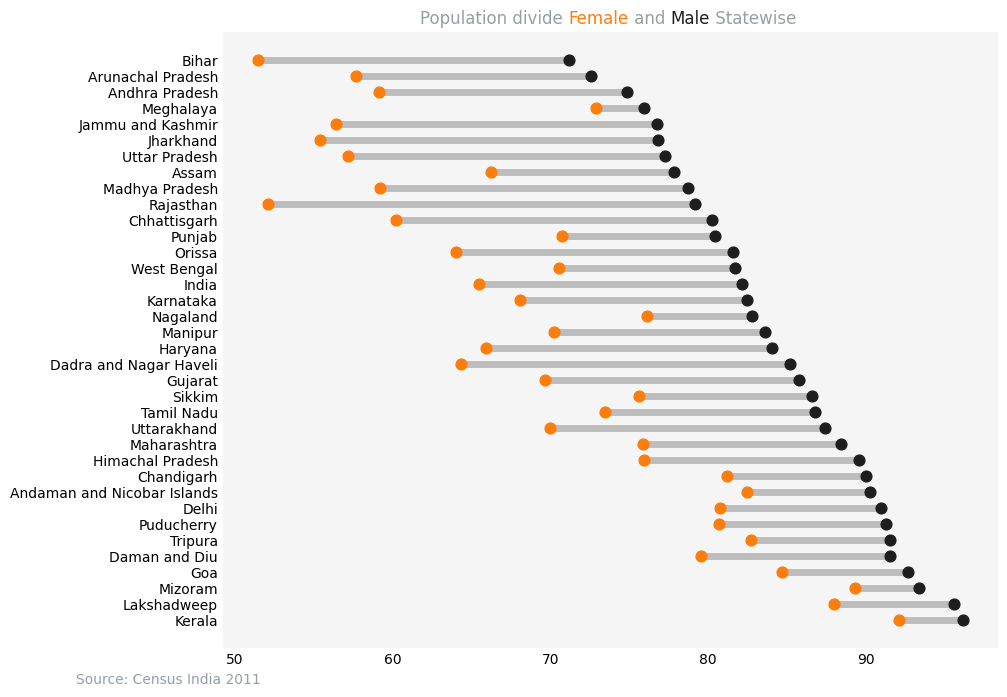

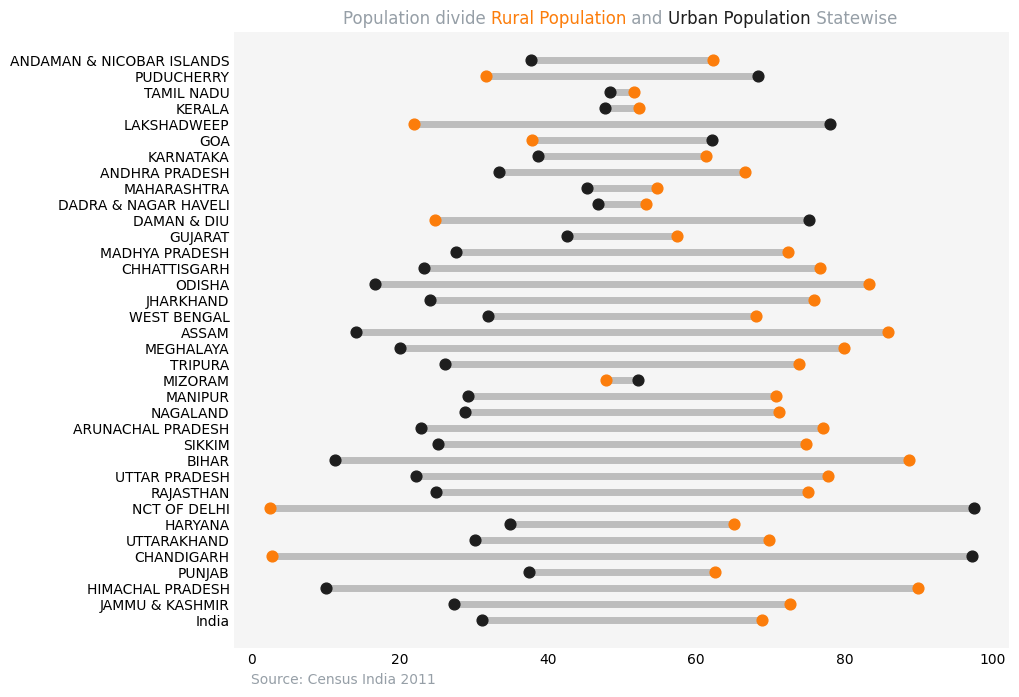

In [70]:
if __name__ == "__main__":
    literacy_data_url = r"https://www.census2011.co.in/literacy.php"
    df_literacy = literary_rate_data(literacy_data_url)
    #print(type(df_literacy))
    #df_literacy.head()
    filename_lit="LiteracyIndiaStatewiseGender.png"
    create_dumbell(df_literacy, "Male", "State", "Female", "State", filename=filename_lit)
    urban_rural_data_url = r"https://censusindia.gov.in/nada/index.php/catalog/42555/download/46181/2011-IndiaState-0000.xlsx"
    df_urban_rural = urban_rural_pop_data(urban_rural_data_url)
    filename_pop="RuralUrbanPopulationStatewise.png"
    create_dumbell(df_urban_rural, "Urban Population", "Name", "Rural Population", "Name", filename=filename_pop)